# Enhanced Sampling with NCE

In [2]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
torch.set_default_dtype(torch.float64)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from sys import exit
import scipy.integrate as integrate
from scipy import optimize


from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.nn import functional as F

In [69]:
params_init = (4, 0.5, 10, 10, 5)
beta_init = 0.2

def true_V_x(x, params=params_init):
    p, a0, a2, m, alpha = params[0], params[1], params[2], params[3], params[4]
    return (p**2)/(2*m) + a0*x**4 - a2*x**2 + alpha*np.sqrt(a0/(2*a2))*x

V_x_np = np.vectorize(true_V_x)
Z = dict()

def p_x(x, range_=(-10, 10), beta=beta_init, params=params_init, V_x = true_V_x):
    E = V_x(x, params)

    if (x < range_[0]) or (x > range_[1]):
        return 0
    
    lower, upper = range_[0], range_[1]

    try:
        Z0 = Z[(beta, params, range_)]
    except:
        Z0 = integrate.quad(lambda x: np.exp(-beta*V_x(x, params)), lower, upper)[0]
        Z[(beta, params, range_)] = Z0
        
    return np.exp(-beta*E)/Z0



Text(0.5, 1.0, 'Energy Landscape')

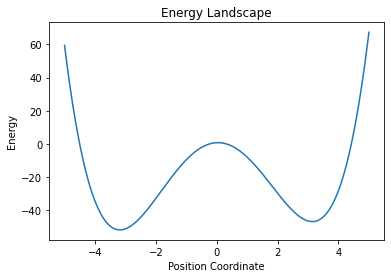

In [71]:
lines = np.linspace(-5, 5, 1000)
V_x_curve = [true_V_x(x) for x in lines]
plt.plot(lines, V_x_curve)
plt.xlabel("Position Coordinate")
plt.ylabel("Energy")
plt.title("Energy Landscape")

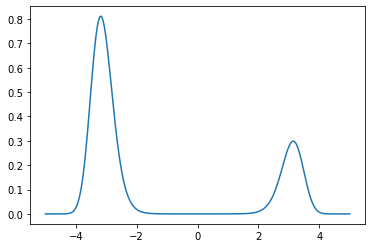

In [73]:
lines = np.linspace(-5, 5, 1000)
p_x_curve = [p_x(x) for x in lines]
plt.plot(lines, p_x_curve)

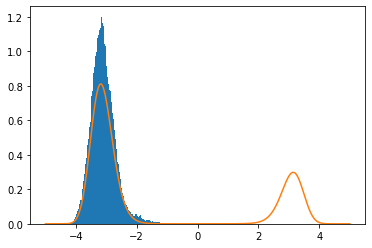

In [76]:
def metropolis_hastings(target_density, range0 = None, size=200000):
    burnin_size = 100000
    size += burnin_size

    x0 = -2.5
    xt = x0

    samples = []

    lower, upper = range0[0], range0[1]

    for i in range(size):
        xt_candidate = np.array([np.random.normal(float(xt), 0.03)])

        if range0 == None:
            accept_prob = (target_density(xt_candidate))/(target_density(xt))
        #fix this shitty code
        else:
            if (xt_candidate < lower) or (xt_candidate > upper):
                accept_prob = 0
            else:
                accept_prob = (target_density(xt_candidate))/(target_density(xt))

        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)

    samples = np.array(samples[burnin_size:])
    return samples

samplesA = metropolis_hastings(p_x, range0 = (-100, 100))

lines = np.linspace(-5, 5, 1000)
normal_curve = [p_x(l) for l in lines]
plt.hist(samplesA, density=1, bins=200) 
plt.plot(lines, normal_curve)

In [90]:
class NCE(nn.Module):
    def __init__(self, noise_dist):
        super(NCE, self).__init__()

        self.U_x = nn.Sequential(
          nn.Linear(1, 30),
          nn.Tanh(),
          nn.Linear(30, 100),
          nn.Tanh(),
          nn.Linear(100, 30),
          nn.Tanh(),
          nn.Linear(30, 1),
        )
        
        self.beta = 0.2
        self.ln_Z = 1

        self.noise_dist = noise_dist

    def forward(self, x):
        return -self.beta*self.U_x(x) - self.ln_Z
        
    def ln_p_m(self, x): #this is U(x)
        #print(x[0])
        return -self.beta*self.U_x(x) - self.ln_Z
    
    def ln_p_n(self, x):
        #print(x[0])
        return self.noise_dist.log_prob(x.to(device)).to(device)
    
    def G_x_theta(self, x):
        #print(x[0])
        return self.ln_p_m(x) - self.ln_p_n(x)

    def h_x_theta(self, x):
        #print(x[0])
        return torch.sigmoid(self.G_x_theta(x))
    
    def loss(self, X_true, Y_true):
        T = X_true.size()[0] + Y_true.size()[0]
        J_T_vec = torch.log(self.h_x_theta(X_true)) + torch.log(1 - self.h_x_theta(Y_true)).to(device)
        return -(1/(2*T))*torch.sum(J_T_vec)

device = torch.device("cpu")

range_min = float(min(samplesA))
range_max = float(max(samplesA))
max_in_region = max(samplesA)
print(range_min, range_max)

samplesA = torch.tensor(samplesA).to(device)
model = NCE(Uniform(min(samplesA)-2, max(samplesA)+2)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.5*1e-3)

-4.252182525132379 -1.1254364824990868


<ipython-input-90-887550882224>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samplesA = torch.tensor(samplesA).to(device)


In [91]:
def train(model, optimizer, true_samples):
    model.train()
    train_loss = 0

    #true_samples = true_samples.to(device)
    #noise_samples = noise_samples.to(device)
    
    t = true_samples
    n = model.noise_dist.sample( (1000, 1) ).to(device)

    optimizer.zero_grad()
    loss = model.loss(t, n)
    loss.backward()

    train_loss += loss.item()
    optimizer.step()

for iter in range(0, 3):
    for epoch in range(1, 100):
        train(model, optimizer, samplesA[1000*epoch:1000*epoch+1000])

<ipython-input-92-9aef2a4b056e>:4: RuntimeWarning: divide by zero encountered in log
  U_x_curve_0 = [-1/beta_init*np.log(p_x(l, range_=(-4,0))) for l in lines]


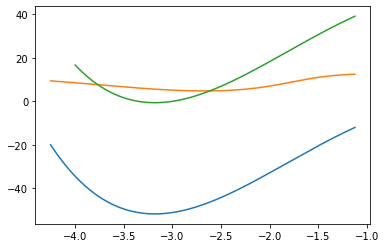

In [92]:
lines = np.linspace(range_min, range_max, 1000)
U_x_curve_true = [true_V_x(l) for l in lines]
learned_U_x_curve = [-1/beta_init*(model(torch.tensor(l).reshape(1,1).to(device))).cpu().detach().numpy()[0][0] for l in lines]
U_x_curve_0 = [-1/beta_init*np.log(p_x(l, range_=(-4,0))) for l in lines]

plt.plot(lines, U_x_curve_true)
plt.plot(lines, learned_U_x_curve)
plt.plot(lines, U_x_curve_0)

/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order

Text(0.5, 1.0, 'New Energy Landscape')

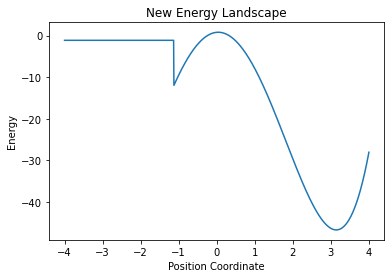

In [93]:
def new_V_x(x, params=params_init):
    if range_min < float(x) < range_max:
        return max_in_region
    else:
        return true_V_x(x, params_init)

lines = np.linspace(-4, 4, 1000)
V_x_curve = [new_V_x(x) for x in lines]
plt.plot(lines, V_x_curve)
plt.xlabel("Position Coordinate")
plt.ylabel("Energy")
plt.title("New Energy Landscape")

/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order

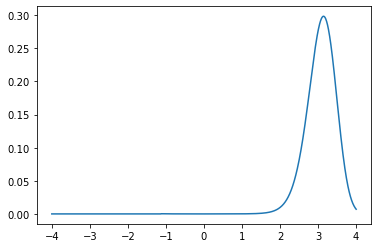

In [88]:
new_p_x = lambda a: p_x(a, V_x=new_V_x)
lines = np.linspace(-4, 4, 1000)
p_x_curve = [new_p_x(x) for x in lines]
plt.plot(lines, p_x_curve)

In [86]:
samplesB = metropolis_hastings(new_p_x, range0 = (-100, 100))

/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order

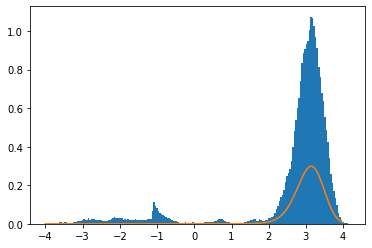

In [89]:
lines = np.linspace(-4, 4, 1000)
normal_curve = [new_p_x(l) for l in lines]
plt.hist(samplesB, density=1, bins=200) 
plt.plot(lines, normal_curve)